In [1]:
import os
import shutil
os.environ['PATH'] += ":/content/mumax3.10"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

In [7]:
# PATH PARAMETERS
rawDataPath = "/home/jiwoop/rnf/tacc/outputs/alp0temp150-10nm.mx3-general-mumax3.sl-17-06_Tuesday_September_19_2023/alp0temp150-10nm.out"
dataPath = rawDataPath.replace(".out", "")

# NAME OF PROCESSED DATA
label = "a(0.0)_temp(150)_10nm"

In [4]:
# NUMERICAL PARAMETERS
fmax = 2e9       # maximum frequency (in Hz) of the sinc pulse
T    = 400e-9      # simulation time (longer -> better frequency resolution)
dt   = 100e-12     # the sample time

In [5]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

In [6]:
def read_mumax3_ovffiles(outputdir):
    """
    Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key
    """
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

In [7]:
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    return table, fields

In [8]:
# RUN MUMAX3 SCRIPT
#table, fields = run_mumax3( script, name="DW_Lattice", verbose=False )

In [9]:
'''
Extract table and fields -- no pickling
'''
name = dataPath

scriptfile = name + ".txt" 
outputdir  = name + ".out"

table = read_mumax3_table(outputdir + "/table.txt") 
fields = read_mumax3_ovffiles(outputdir)

In [10]:
'''
Extract table and fields, after simulation has run on TACC, etc.
'''
import pickle

name = dataPath

scriptfile = name + ".txt" 
outputdir  = name + ".out"

table = read_mumax3_table(outputdir + "/table.txt") 
fields = read_mumax3_ovffiles(outputdir)

# table.to_csv(label + ".csv")
table.to_pickle(label + "Table.pkl")
# SERIALIZE DICT (FIELDS)
with open(label + "Field.pkl", "wb") as handle:
    pickle.dump(fields, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# MOVE .CSV FILE(TABLE) TO pyData
# MOVE 
shutil.move("/home/jiwoop/rnf/dwlattice/micromagnetics/a(0.0)_temp(150).csv", "/home/jiwoop/rnf/dwlattice/micromagnetics/pyData")

'/home/jiwoop/rnf/dwlattice/micromagnetics/pyData/a(0.0)_temp(150).csv'

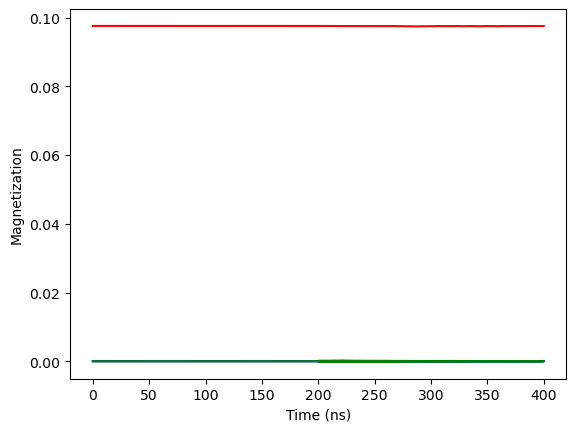

In [11]:
# MAGNETIZATION v. TIME (ns)
plt.figure()

nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"], color='red')
plt.plot( table["t"]/nanosecond, table["my"], color='blue')
plt.plot( table["t"]/nanosecond, table["mz"], color='green')

plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")

plt.show()

In [12]:
'''
Return the value of DW position in a cell.
(By finding a point where mz == 0)
'''
def bisect(f, x_lo, x_hi, n):
    # midpoint
    x_o = (x_lo + x_hi) / 2.0
    # base case, run enough to converge.
    if n == 0:
        return x_o
    # base case, at x_o is 0
    if f(x_o) == 0:
        return x_o
    
    # ascending (-1 --> 1)
    if f(x_lo) < f(x_hi):
        if f(x_o) > 0:
            x_o = bisect(f, x_lo, x_o, n-1)
        else:
            x_o = bisect(f, x_o, x_hi, n-1)
    # descending (1 --> -1)
    else:
        if f(x_o) < 0:
            x_o = bisect(f, x_lo, x_o, n-1)
        else:
            x_o = bisect(f, x_o, x_hi, n-1)
    return x_o


In [13]:
def findDW(m):
    # *Global* values/ variables
    x_total = m.shape[3]
    y_total = m.shape[2]
    x_mid = int(m.shape[3]/2)

    DW_array = []
    DW_pos = []

    nDW = 0.0
    flag = False

    for iy in range(y_total):
        mx = m[0,0,iy,x_mid]
        my = m[1,0,iy,x_mid]
        mz = m[2,0,iy,x_mid]
        empty = (mx==0) and (my==0) and (mz==0)

        if empty:
            # Just got off the racetrack.
            if flag == True:
                DW_array.append(sum(DW_pos) / nDW)
                DW_pos = []
                nDW = 0
                flag = False
        else:
            # Just entered the racetrack.
            if flag == False:
                flag = True
            f = Rbf(np.arange(x_total), m[2,0,iy,:])
            DW_pos.append(bisect(f, 0, x_total, 15))
            nDW += 1
    
    return DW_array

In [14]:
# EVEN NUMBERED RACETRACK
def findDW_A(m):
    # *Global* values/ variables
    x_total = m.shape[3]
    y_total = m.shape[2]
    x_mid = int(m.shape[3]/2)

    DW_array = []
    DW_pos = []

    nDW = 0.0
    flag = False
    count = -1

    for iy in range(y_total):
        mx = m[0,0,iy,x_mid]
        my = m[1,0,iy,x_mid]
        mz = m[2,0,iy,x_mid]
        empty = (mx==0) and (my==0) and (mz==0)

        if empty:
            # Just got off the racetrack.
            if flag == True:
                if count%2 == 0:
                    DW_array.append(sum(DW_pos) / nDW)
                DW_pos = []
                nDW = 0
                flag = False
        else:
            # Just entered the racetrack.
            if flag == False:
                flag = True
                count += 1
            f = Rbf(np.arange(x_total), m[2,0,iy,:]) 
            DW_pos.append(bisect(f, 0, x_total, 15))
            nDW += 1
    
    return DW_array

In [15]:
# ODD NUMBER RACETRACK
def findDW_B(m):
    # *Global* values/ variables
    x_total = m.shape[3]
    y_total = m.shape[2]
    x_mid = int(m.shape[3]/2)

    DW_array = []
    DW_pos = []

    nDW = 0.0
    flag = False
    count = -1

    for iy in range(y_total):
        mx = m[0,0,iy,x_mid]
        my = m[1,0,iy,x_mid]
        mz = m[2,0,iy,x_mid]
        empty = (mx==0) and (my==0) and (mz==0)

        if empty:
            # Just got off the racetrack.
            if flag == True:
                if count%2 != 0:
                    DW_array.append(sum(DW_pos) / nDW)
                DW_pos = []
                nDW = 0
                flag = False
        else:
            # Just entered the racetrack.
            if flag == False:
                flag = True
                count += 1
            f = Rbf(np.arange(x_total), m[2,0,iy,:]) 
            DW_pos.append(bisect(f, 0, x_total, 15))
            nDW += 1
    
    return DW_array

In [15]:
# POSITION OF DW IN LIST
pos = []
posE = []
posO = []

for key in sorted(fields.keys()):
    if "regions" in str(key):
        continue
    pos.append(findDW(fields[key]))
    posE.append(findDW_A(fields[key]))
    print("Processing: " + str(key))
    posO.append(findDW_B(fields[key]))


Processing: m000000
Processing: m000001
Processing: m000002
Processing: m000003
Processing: m000004
Processing: m000005
Processing: m000006
Processing: m000007
Processing: m000008
Processing: m000009
Processing: m000010
Processing: m000011
Processing: m000012
Processing: m000013
Processing: m000014
Processing: m000015
Processing: m000016
Processing: m000017
Processing: m000018
Processing: m000019
Processing: m000020
Processing: m000021
Processing: m000022
Processing: m000023
Processing: m000024
Processing: m000025
Processing: m000026
Processing: m000027
Processing: m000028
Processing: m000029
Processing: m000030
Processing: m000031
Processing: m000032
Processing: m000033
Processing: m000034
Processing: m000035
Processing: m000036
Processing: m000037
Processing: m000038
Processing: m000039
Processing: m000040
Processing: m000041
Processing: m000042
Processing: m000043
Processing: m000044
Processing: m000045
Processing: m000046
Processing: m000047
Processing: m000048
Processing: m000049


: 

: 

In [1]:
"""
Saving copy
"""
f = open("posData/pos_" + label + ".txt", mode="w")
f.write(str(pos))

f = open("posData/posE_" + label + ".txt", mode="w")
f.write(str(posE))

f = open("posData/posO_" + label + ".txt", mode="w")
f.write(str(posO))

NameError: name 'label' is not defined

In [ ]:
'''
Pos data extraction
'''
from ast import literal_eval
# 1. IMPORT .TXT AS STRING
posStr = open("posData/pos_" + label + ".txt", "r").read()
posEvenStr = open("posData/posE_" + label + ".txt", 'r').read()
posOddStr = open("posData/posO_" + label + ".txt", "r").read()

# 2. CONVERT .TXT TO LIST
posList = literal_eval(posStr)
posEList = literal_eval(posEvenStr)
posOList = literal_eval(posOddStr)

# 3. CONVERT LIST TO NP ARRAY
pos = np.array(posList)
posE = np.array(posEList)
posO = np.array(posOList)

In [ ]:
# Apply the two dimensional FFT
posE_fft = np.fft.fft2(posE)
posO_fft = np.fft.fft2(posO)
# posE_fft = np.fft.fftshift(posE_fft)
# posO_fft = np.fft.fftshift(posO_fft)

A = np.add(np.abs(posE_fft)**2, np.abs(posO_fft)**2)
# A = np.abs(posE_fft)**2
# B = np.abs(posO_fft)**2

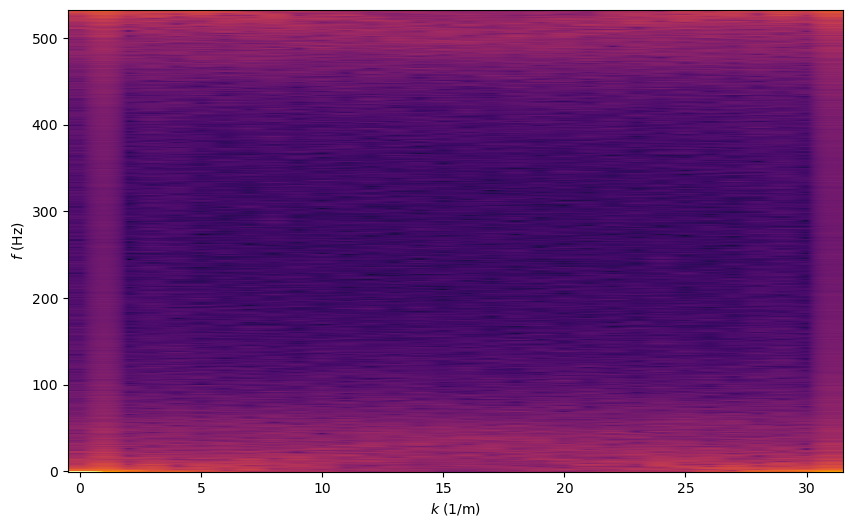

In [ ]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(10,6))

# Show the intensity plot of the 2D FFT
# extent = [ -(2*np.pi)/(2*dx), (2*np.pi)/(2*dx), -1/(2*dt), 1/(2*dt)] # extent of k values and frequencies

# plt.imshow(np.abs(posA_fft)**2, extent=extent, aspect='auto', origin='lower', cmap="inferno")
# plt.imshow(np.abs(posB_fft)**2, extent=extent, aspect='auto', origin='lower', cmap="inferno")
plt.imshow(A, aspect='auto', origin='lower', cmap="inferno", norm=LogNorm())
#plt.imshow(A, aspect='auto', origin='lower', cmap="inferno")

# plt.xlim([-2e8,2e8])
# plt.ylim([0,fmax])
plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")

plt.savefig("plots/" + label + "_bandStruct.png")
plt.show()

In [ ]:
# Plot positions along racetracks
by_track = np.transpose(pos)

534


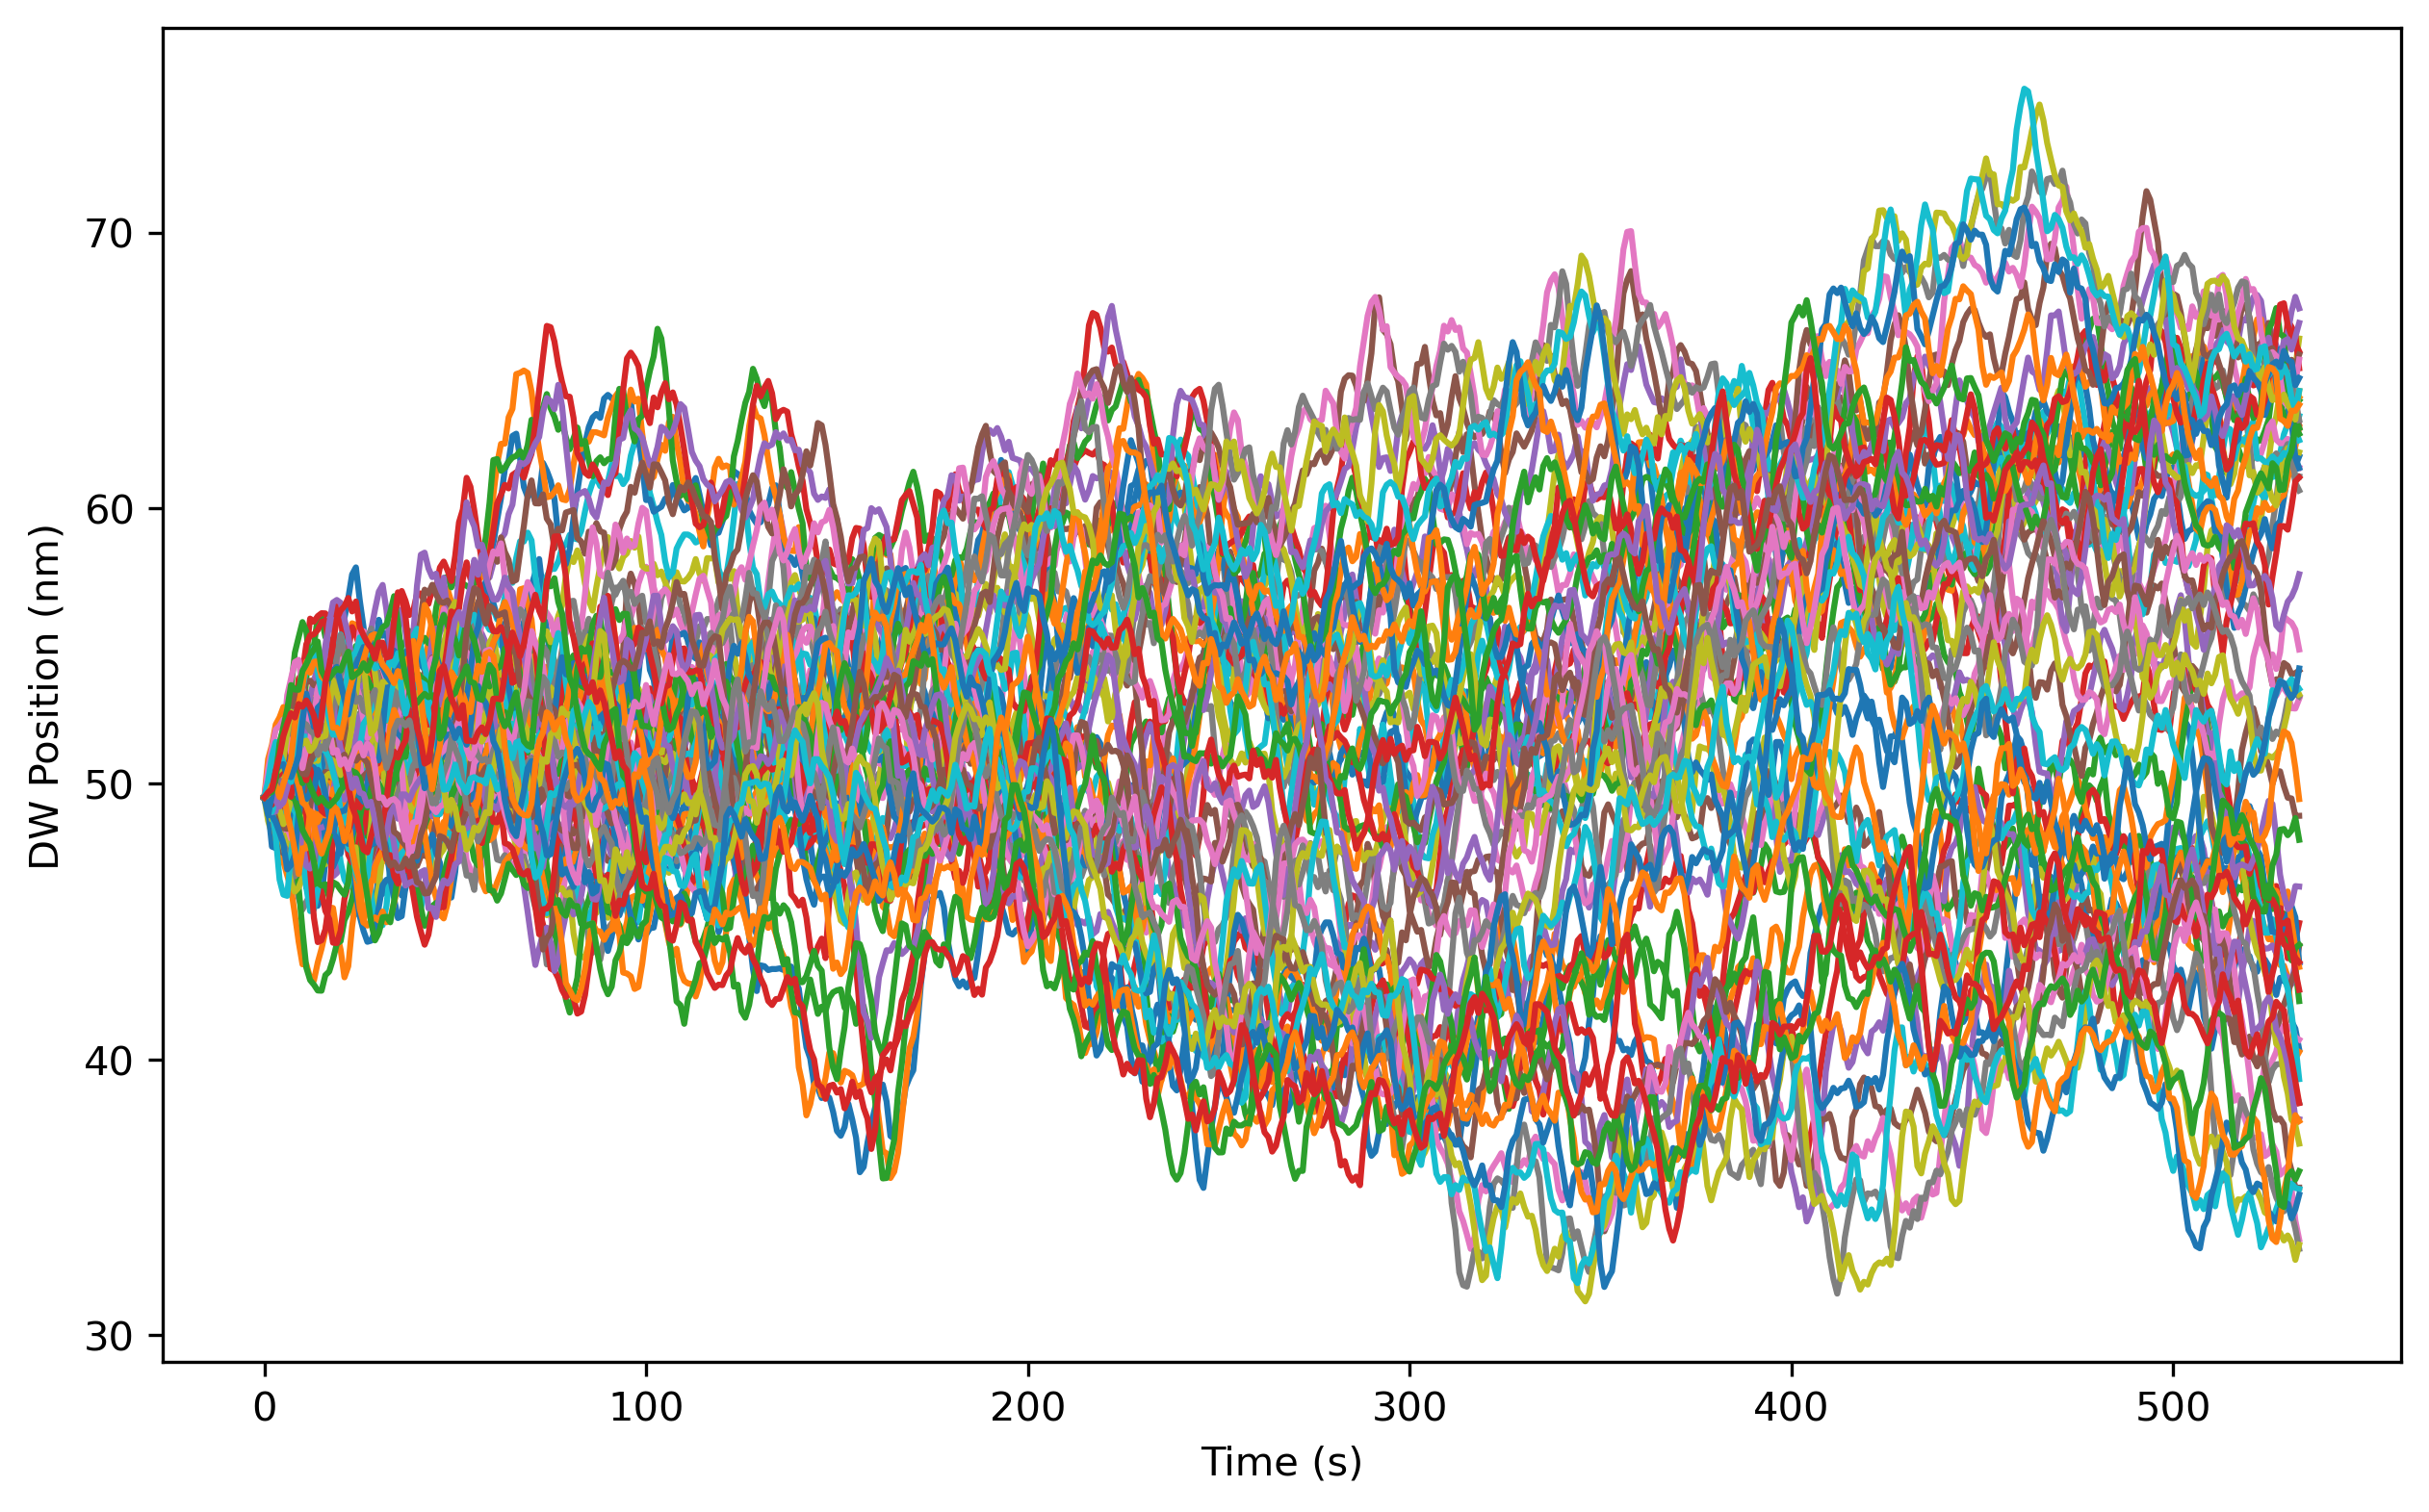

In [ ]:
n_racetrack = range(by_track.shape[0])
t = range(by_track.shape[1])

plt.figure(figsize=(10, 6), dpi=300)

for nth in n_racetrack:
    plt.plot(t, by_track[nth], label=str(nth+1)+'th')

# plt.legend(loc="upper left", fontsize='5')

In [ ]:
from importlib import reload

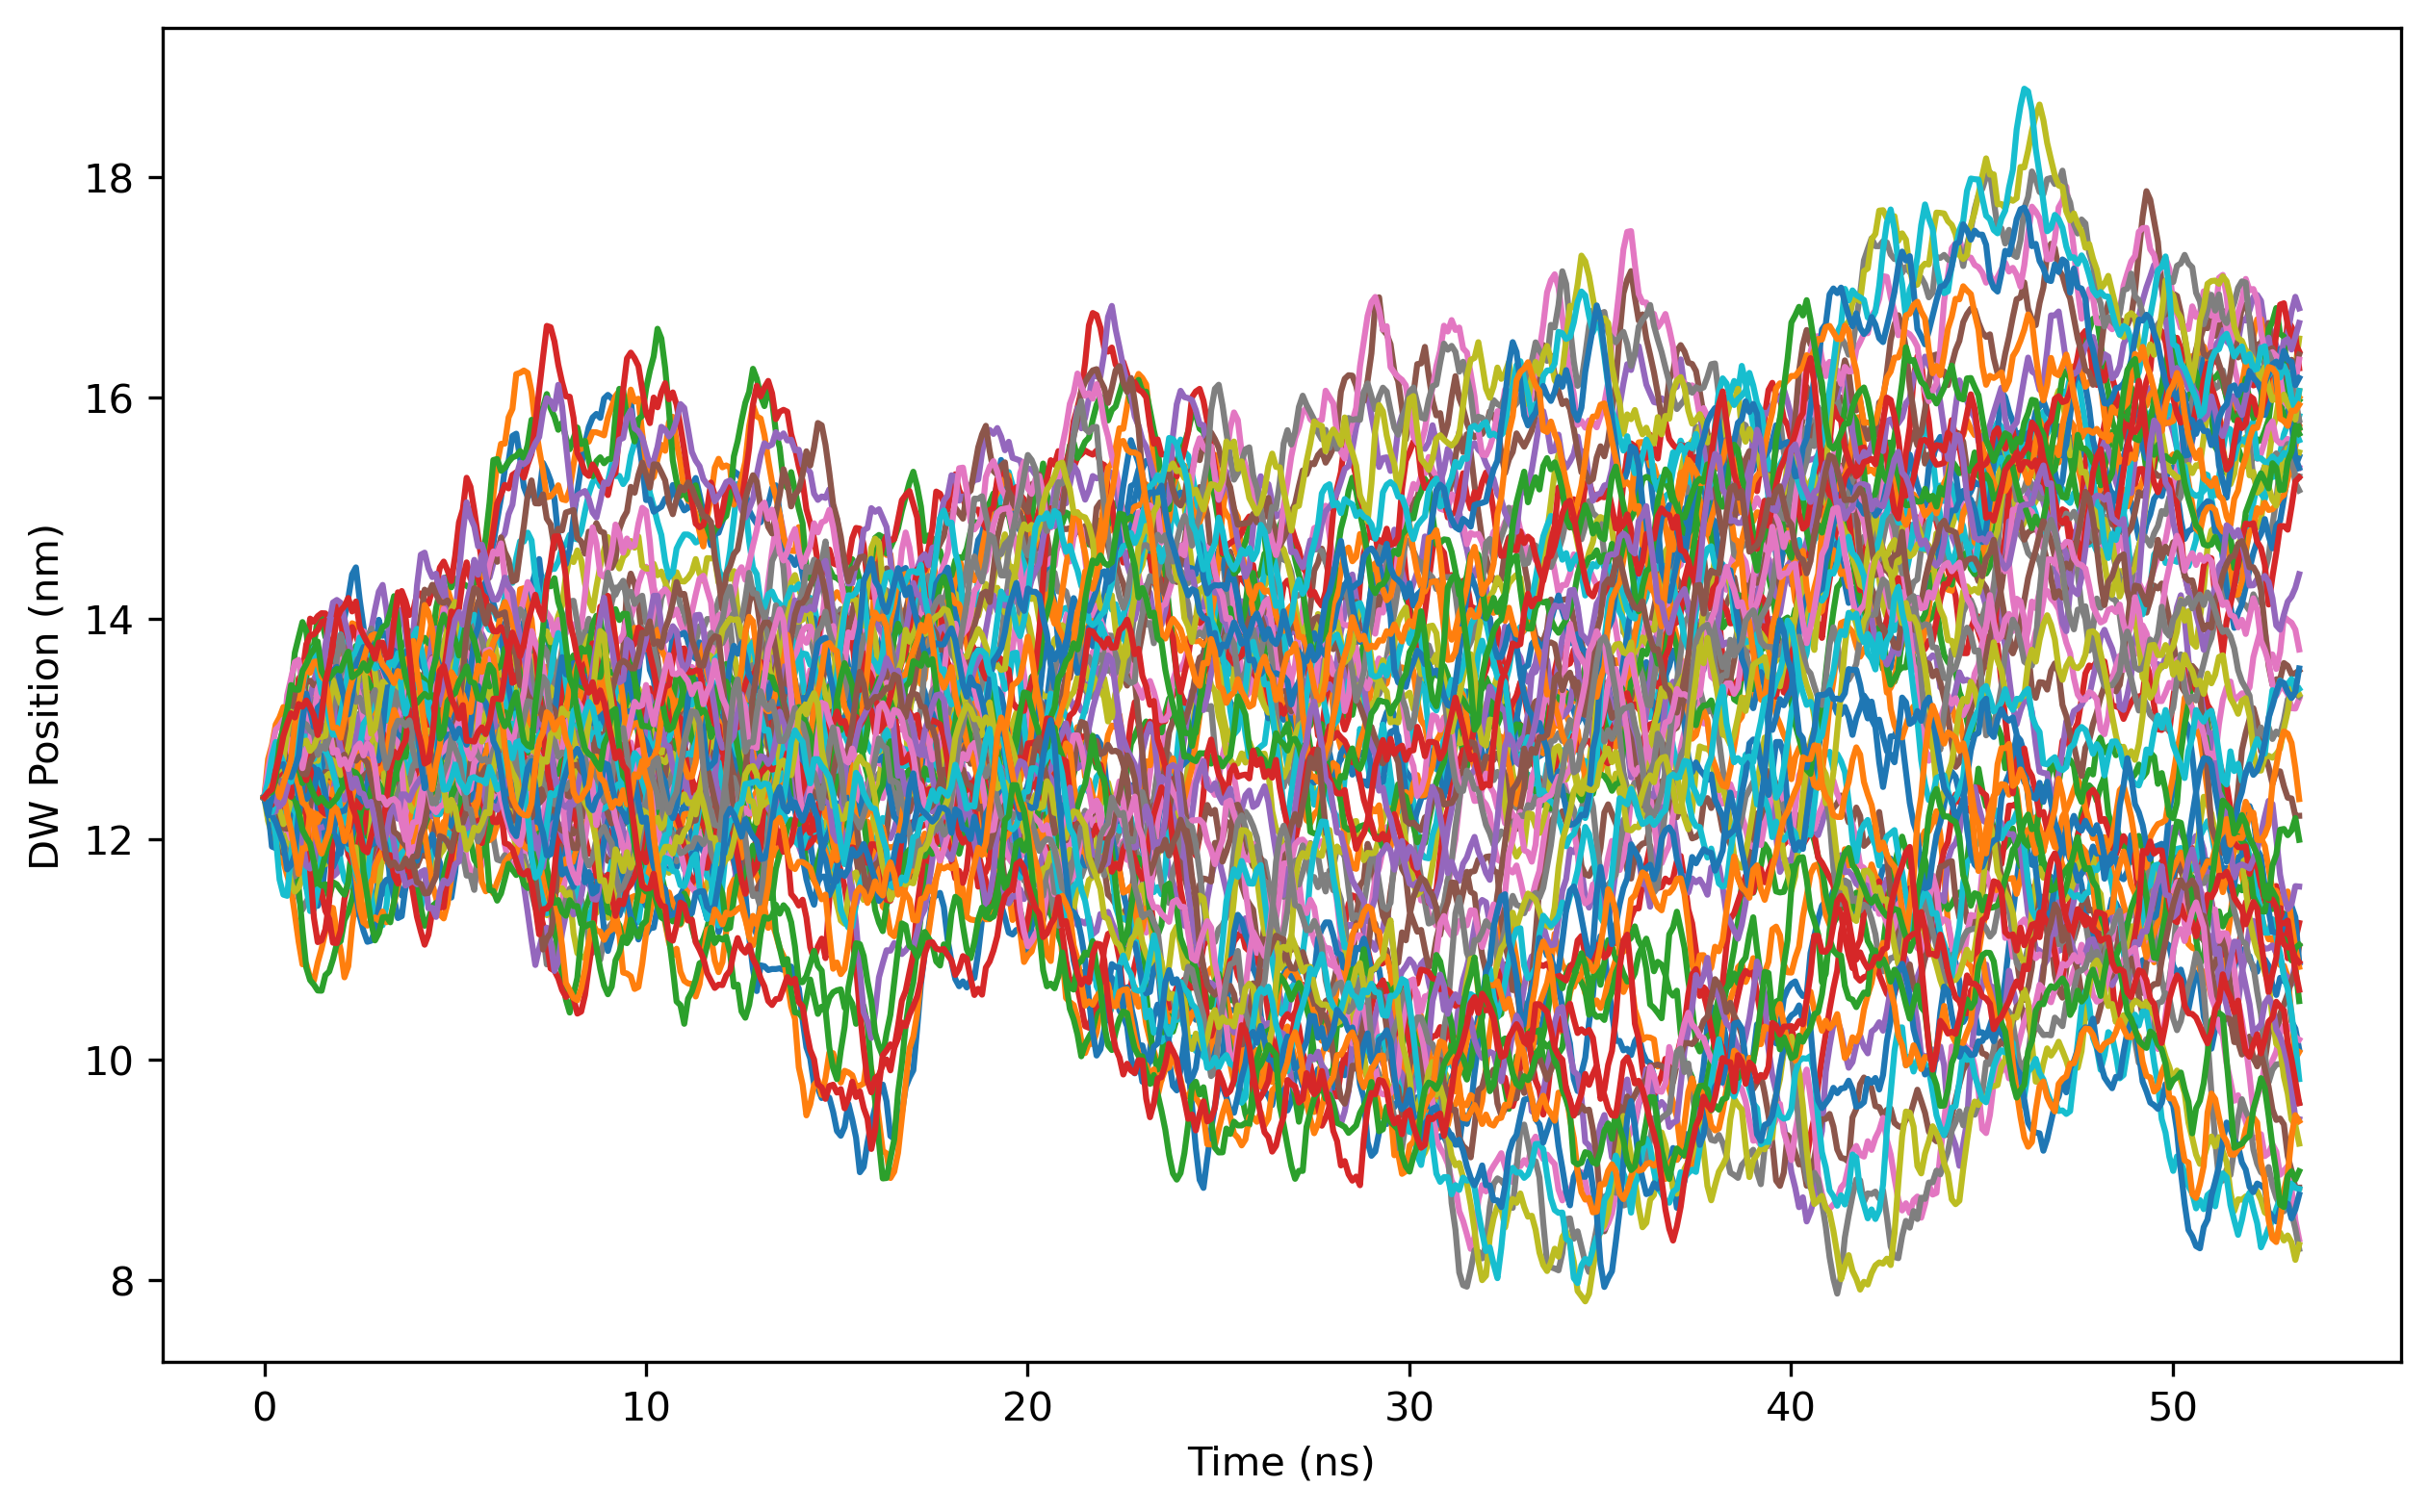

In [ ]:
plt = reload(plt)

n_racetrack = range(by_track.shape[0])

plt.figure(figsize=(10, 6), dpi=300)

# s, m version
# T_vals = np.linspace(0, T, int(T/dt)+1)[:by_track.shape[1]]
# resize_track = by_track * 0.25e-9

# ns, nm version
T_vals = np.linspace(0, T, int(T/dt)+1)[:by_track.shape[1]] * 1e9
resize_track = by_track * 0.25

for nth in n_racetrack:
    plt.plot(T_vals, resize_track[nth], label=str(nth+1)+'th')

# ns, nm version
plt.xlabel("Time (ns)")
plt.ylabel("DW Position (nm)")
plt.savefig("plots/" + label + "_thin_pos_v_t.png")

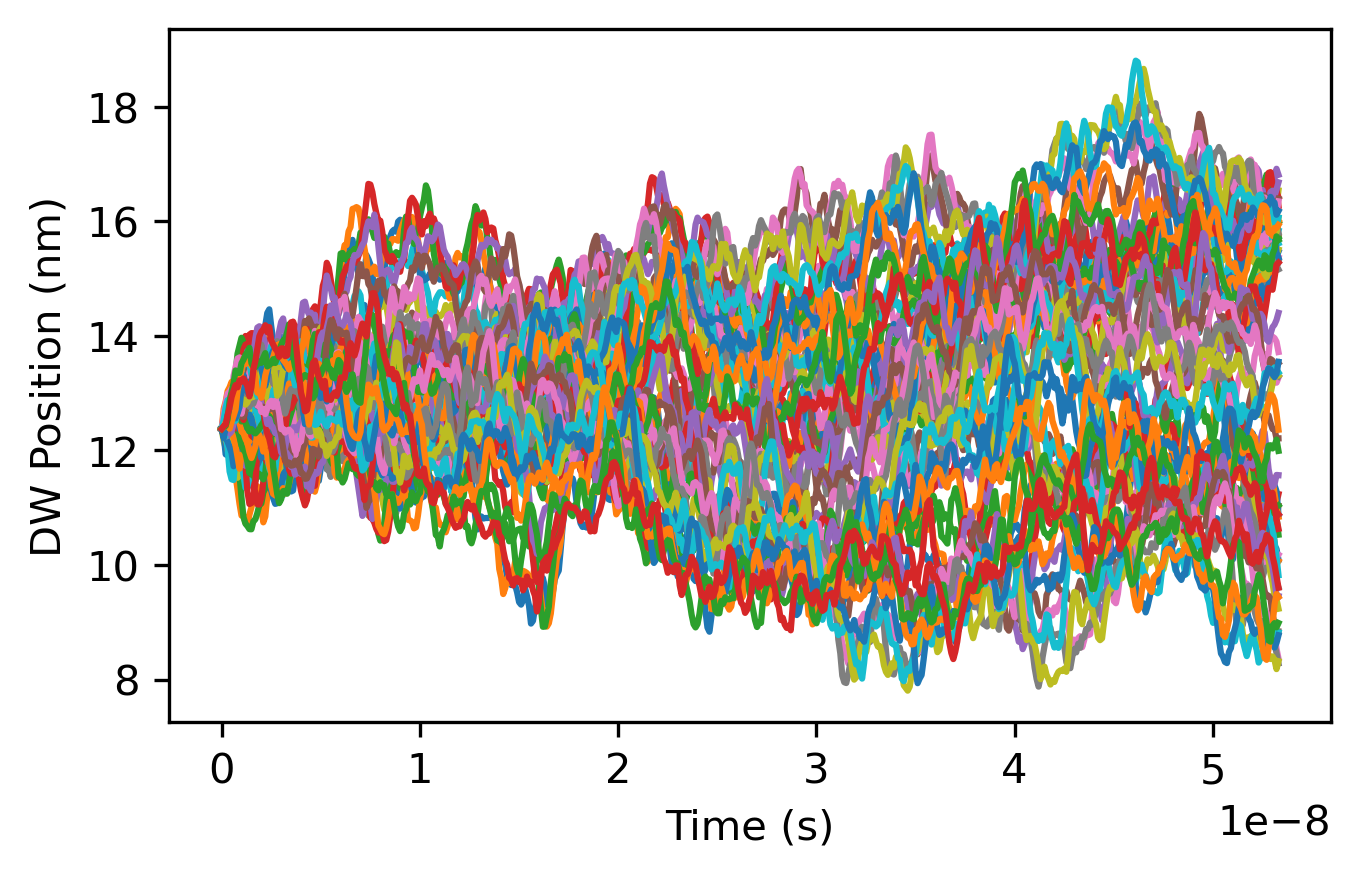

In [ ]:
plt = reload(plt)

n_racetrack = range(by_track.shape[0])
T_vals = np.linspace(0, T, int(T/dt)+1)[:by_track.shape[1]]

plt.figure(figsize=(5, 3), dpi=300)
# m version
# resize_track = by_track * 0.25e-9
# nm version
resize_track = by_track * 0.25

for nth in n_racetrack:
    plt.plot(T_vals, resize_track[nth], label=str(nth+1)+'th')
    

# m version
# plt.xlabel("Time (s)")
# plt.ylabel("DW Position (m)")

# nm version
plt.xlabel("Time (s)")
plt.ylabel("DW Position (nm)")
plt.savefig("plots/" + label + "_pos_v_t.png")